In [1]:
%cd ..

/tempory/NeuralNetworksDIY


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn import manifold, cluster, metrics
from sklearn.preprocessing import OneHotEncoder
from tqdm.autonotebook import tqdm
from utils.mltools import *


/tmp/ipykernel_32486/3641443625.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
sns.color_palette("deep")

def add_2d_scatter(fig, ax, points, point_color, title=None):
    x, y = points.T
    data = pd.DataFrame({"x": x, "y": y, "label": point_color}).sort_values(by="label")
    sns.despine(fig, left=True, bottom=True)
    sns.scatterplot(
        data=data, x="x", y="y", hue="label", linewidth=0, s=10, ax=ax, palette="deep"
    )
    # plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0)
    ax.set_title(title)


def plot_tsne(X_decoded, y):
    fig, ax = plt.subplots(ncols=4, figsize=(6.5 * 4, 6.5))
    for i, perplexity in tqdm(enumerate([10, 30, 50, 100]), total=4):
        tsne = manifold.TSNE(n_jobs=-1, perplexity=perplexity)
        x_reduced = tsne.fit_transform(X_decoded)
        add_2d_scatter(fig, ax[i], x_reduced, y, "")
        ax[i].set_title(f"Perplexity = {perplexity}")


# Dataloading
## Mnist

In [4]:
def load_data(rootdir, class_list=None, trim: float = 0.5):
    def normalize_batch_image(X):
        mn = np.min(X)
        mx = np.max(X)
        X_norm = (X - mn) * (1.0 / (mx - mn))
        return X_norm

    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    # Filtering requested class
    if class_list:
        train = train[train["label"].isin(class_list)]
    y_train = train["label"].values
    X_train = train.drop(columns="label").values

    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    # Filtering requested class
    if class_list:
        test = test[test["label"].isin(class_list)]
    y_test = test["label"].values
    X_test = test.drop(columns="label").values

    trim_train = int(len(X_train) * trim)
    # trim_test = int(len(X_test) * trim)
    trim_test = int(len(X_test))

    # Normalization + trimming
    X_train = normalize_batch_image(X_train[:trim_train, :])
    X_test = normalize_batch_image(X_test[:trim_test, :])
    y_train = y_train[:trim_train]
    y_test = y_test[:trim_test]

    return (X_train, X_test, y_train, y_test)


rootdir = "./data/fashion-mnist/"
X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = load_data(rootdir, trim=0.5)

y_train_oh_mnist = OneHotEncoder().fit_transform(y_train_mnist.reshape(-1, 1)).toarray()
y_test_oh_mnist = OneHotEncoder().fit_transform(y_test_mnist.reshape(-1, 1)).toarray()


## Usps

In [5]:
def normalize_batch_image(X):
    mn = np.min(X)
    mx = np.max(X)
    X_norm = (X - mn) * (1.0 / (mx - mn))
    return X_norm

def load_usps(fn):
    with open(fn, "r") as f:
        f.readline()
        data = [[float(X) for X in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)
    return normalize_batch_image(tmp[:, 1:]), tmp[:, 0].astype(int)

X_train_usps, y_train_usps = load_usps("./data/usps/USPS_train.txt")
X_test_usps, y_test_usps = load_usps("./data/usps/USPS_test.txt")
y_train_oh_usps = OneHotEncoder().fit_transform(y_train_usps.reshape(-1, 1)).toarray()
y_test_oh_usps = OneHotEncoder().fit_transform(y_test_usps.reshape(-1, 1)).toarray()

# t-SNE

## mnist

Big model

In [6]:
with open("./models/fashion-mnist_30_epoch_big_net.pkl", "rb") as f:
    model = pickle.load(f).network
    n_module = len(model.modules)
    model.modules = model.modules[:n_module//2] # use only encoder to forward
X_test_mnist_decoded = model.forward(X_test_mnist)
X_train_mnist_decoded = model.forward(X_train_mnist)
assert X_test_mnist_decoded.shape[1] == 64

## usps

In [7]:
with open("./models/usps_30_epoch_medium_net.pkl", "rb") as f:
    model = pickle.load(f).network
    n_module = len(model.modules)
    model.modules = model.modules[:n_module//2] # use only encoder to forward
X_test_usps_decoded = model.forward(X_test_usps)
X_train_usps_decoded = model.forward(X_train_usps)
assert X_test_usps_decoded.shape[1] == 64

## T-SNE

  0%|          | 0/4 [00:00<?, ?it/s]

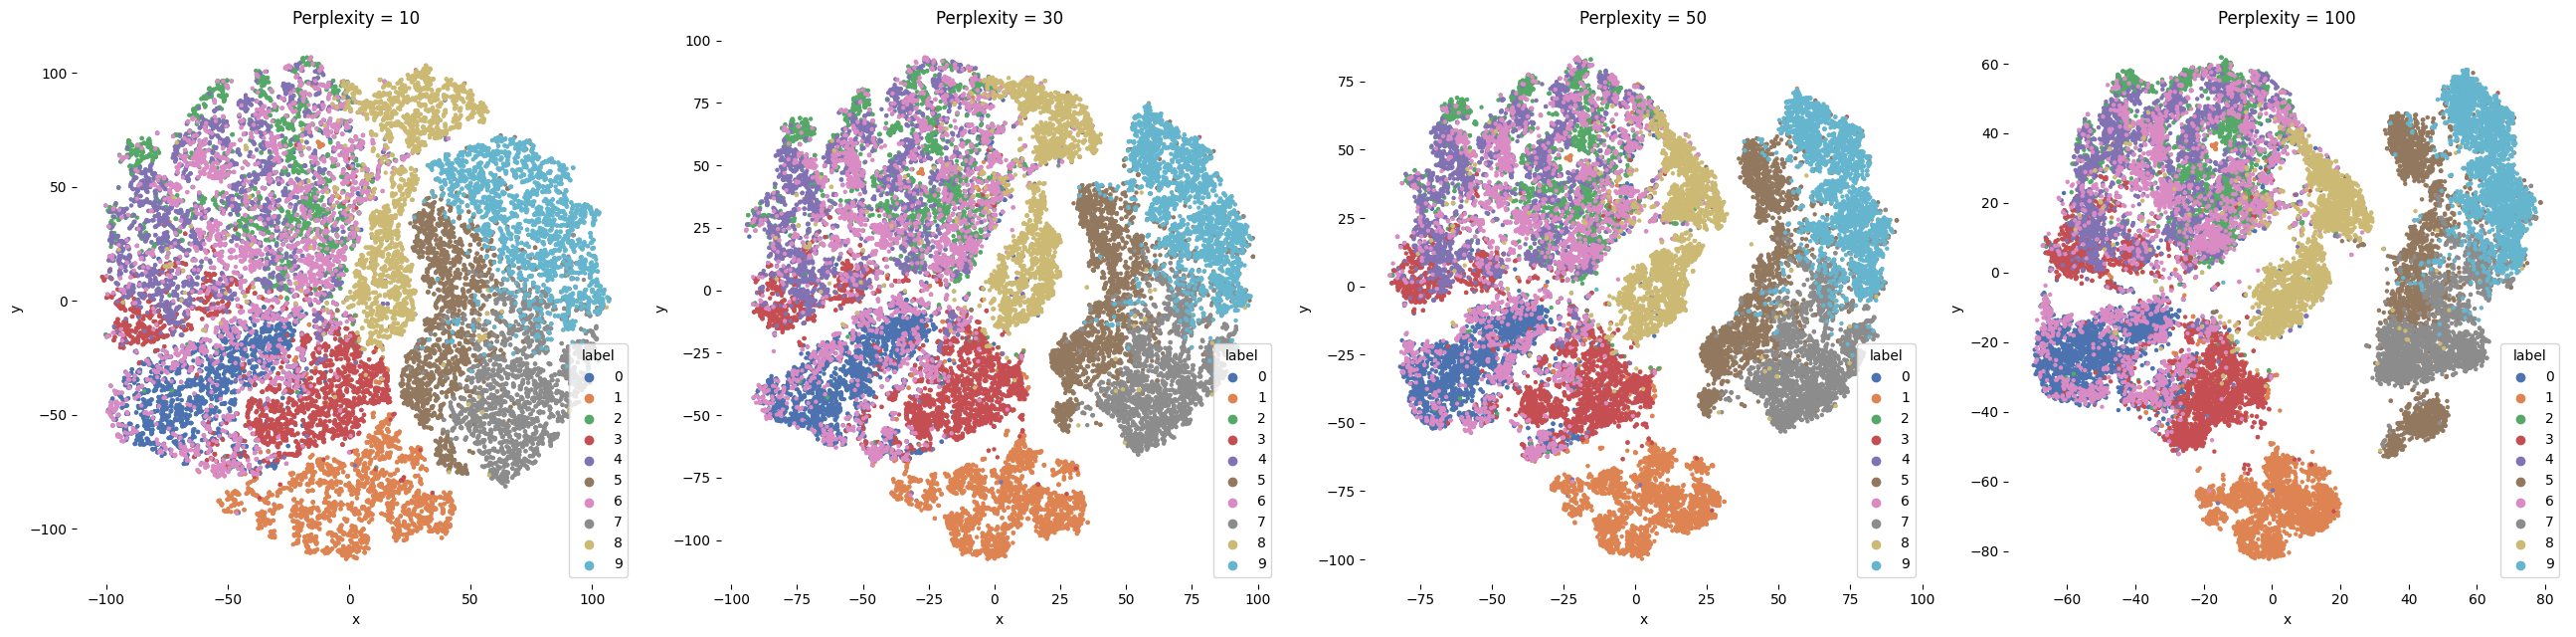

In [8]:
plot_tsne(X_train_mnist_decoded, y_train_mnist)
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig("reports/src/tsne_mnist_train_big.pdf", dpi=100, bbox_inches="tight")

  0%|          | 0/4 [00:00<?, ?it/s]

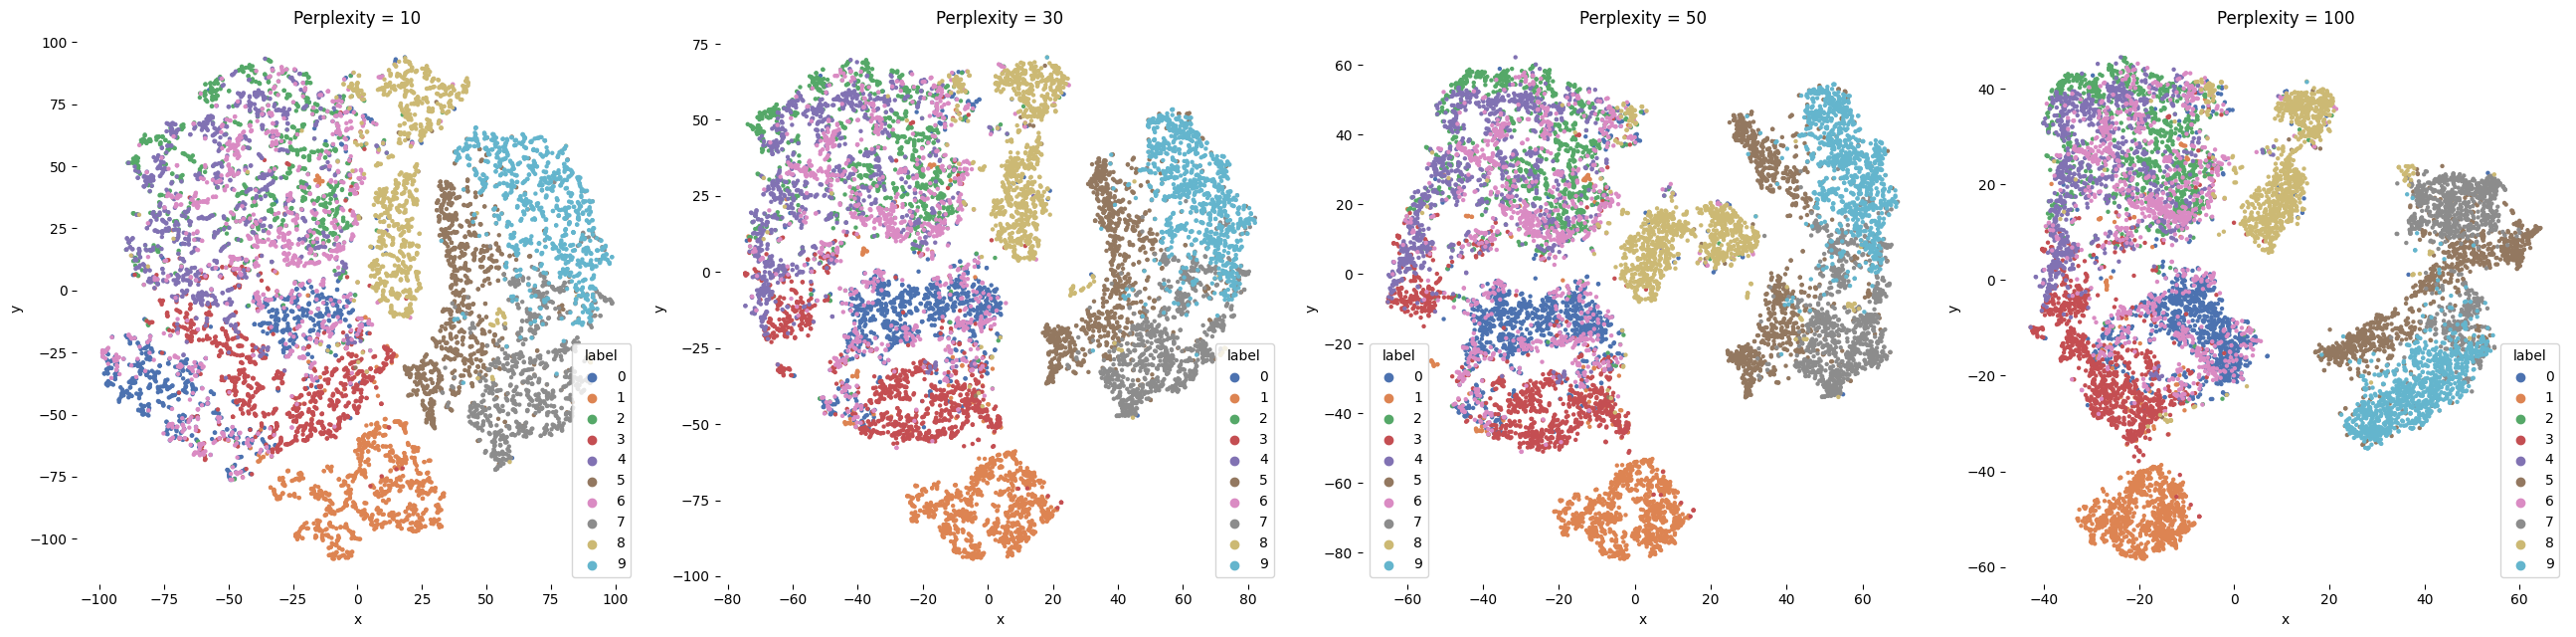

In [9]:
plot_tsne(X_test_mnist_decoded, y_test_mnist)
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig("reports/src/tsne_mnist_test_big.pdf", dpi=100, bbox_inches="tight")

  0%|          | 0/4 [00:00<?, ?it/s]

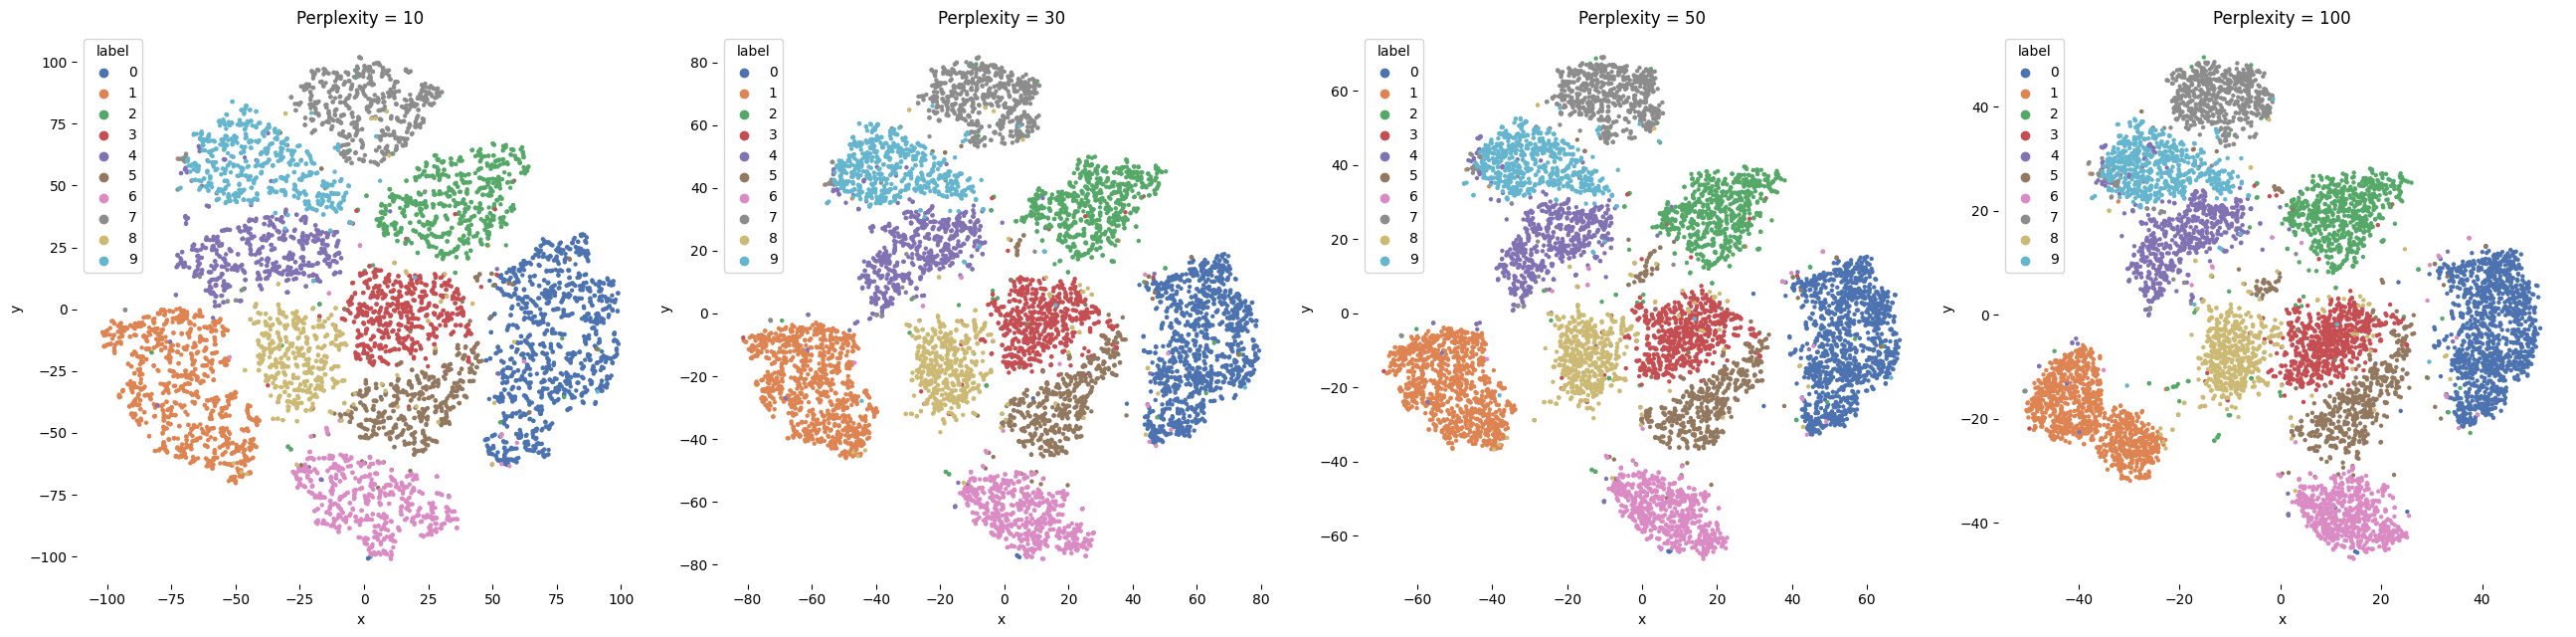

In [10]:
plot_tsne(X_train_usps_decoded, y_train_usps)
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig("reports/src/tsne_usps_train_big.pdf", dpi=100, bbox_inches="tight")

  0%|          | 0/4 [00:00<?, ?it/s]

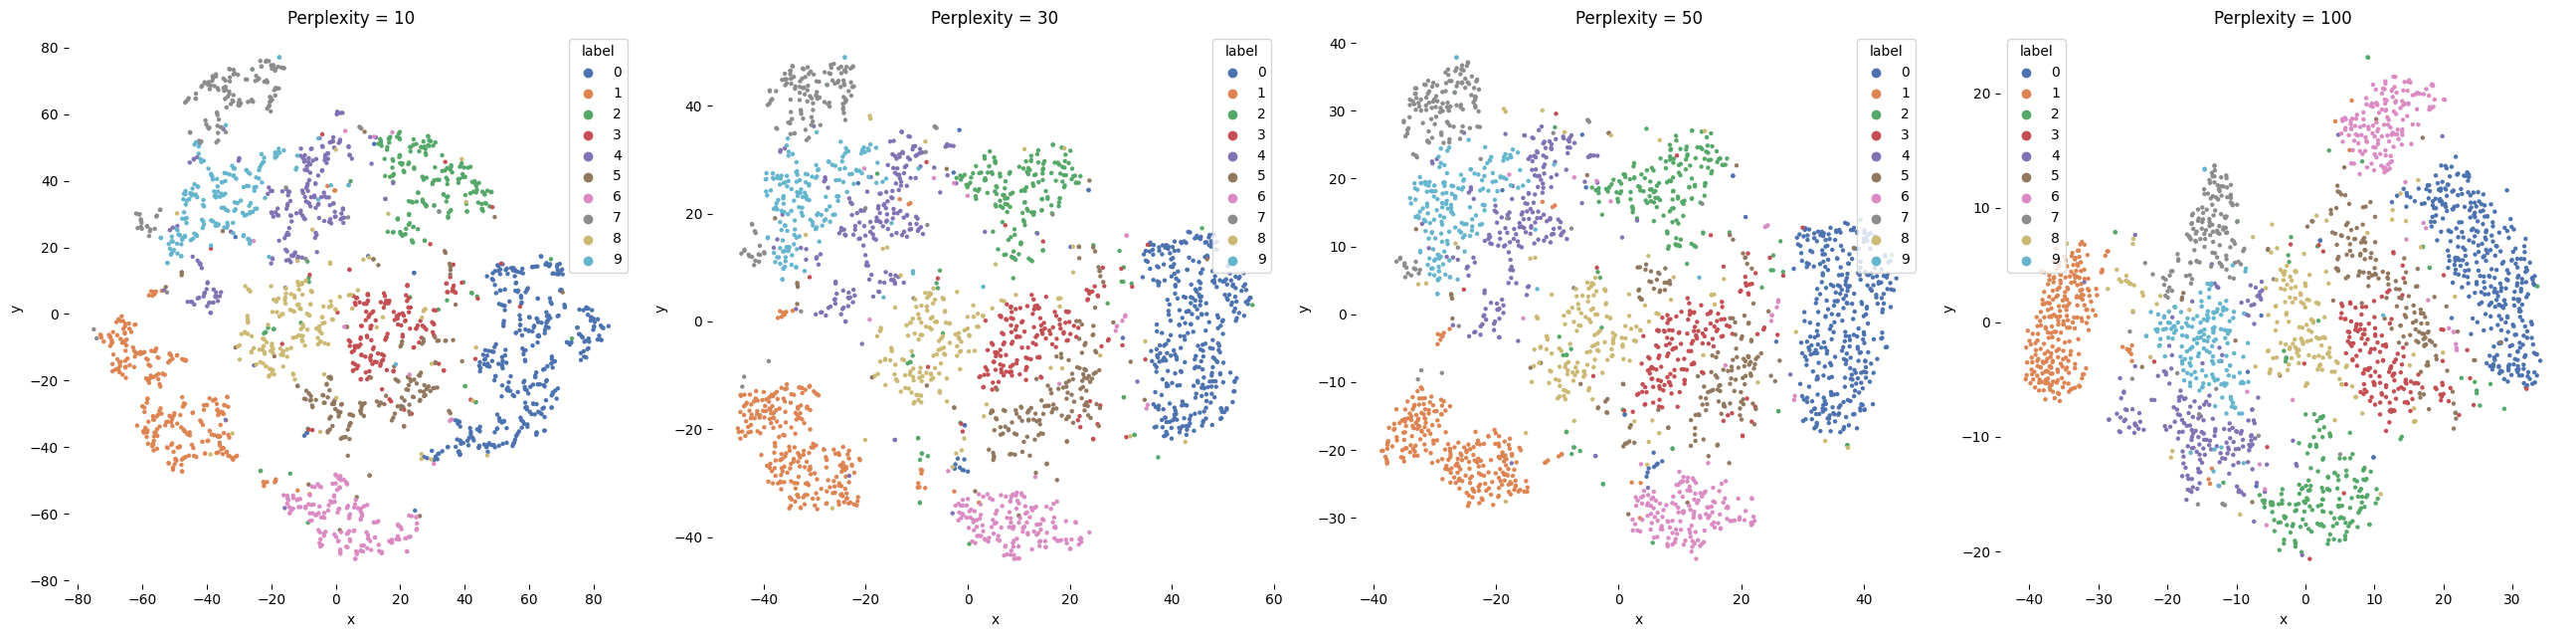

In [11]:
plot_tsne(X_test_usps_decoded, y_test_usps)
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig("reports/src/tsne_usps_test_big.pdf", dpi=100, bbox_inches="tight")

On voit que certaine class doivent être mal reconstitué, voyons voir

In [12]:
plt.figure(figsize=(20, 4))
for i in range(nb_class):
    first_class_img = X_test[np.nonzero(y_test == i)[0][0]].reshape(1, -1)

    # display original
    ax = plt.subplot(2, nb_class, i + 1)
    plt.imshow(first_class_img.reshape(28, 28))
    plt.title(f"Class {i}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, nb_class, i + 1 + nb_class)
    plt.imshow(model(first_class_img).reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


NameError: name 'nb_class' is not defined

<Figure size 2000x400 with 0 Axes>

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(nb_class):
    first_class_img = X_test[np.nonzero(y_test == i)[0][1]].reshape(1, -1)

    # display original
    ax = plt.subplot(2, nb_class, i + 1)
    plt.imshow(first_class_img.reshape(28, 28))
    plt.title(f"class {i}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, nb_class, i + 1 + nb_class)
    plt.imshow(model(first_class_img).reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Ca a l'air d'aller en vrais

# Isomap

In [13]:
def plot_isomap(X_decoded, y):
    fig, ax = plt.subplots(ncols=4, figsize=(6.5 * 4, 6.5))
    for i, n_neighbors in tqdm(enumerate([3,5,7,10]), total=4):
        isomap = manifold.Isomap(n_jobs=-1, n_neighbors=n_neighbors)
        x_reduced = isomap.fit_transform(X_decoded)
        add_2d_scatter(fig, ax[i], x_reduced, y, "")
        ax[i].set_title(f"n_neighbors = {n_neighbors}")

In [14]:
plot_isomap(X_train_mnist_decoded, y_train_mnist)
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig("reports/src/isomap_mnist_train_big.pdf", dpi=100, bbox_inches="tight")

  0%|          | 0/4 [00:00<?, ?it/s]

/tempory/NeuralNetworksDIY/.venv/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/tempory/NeuralNetworksDIY/.venv/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
plot_isomap(X_test_mnist_decoded, y_test_mnist)
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig("reports/src/isomap_mnist_test_big.pdf", dpi=100, bbox_inches="tight")

In [ ]:
plot_isomap(X_train_usps_decoded, y_train_usps)
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig("reports/src/isomap_usps_train_big.pdf", dpi=100, bbox_inches="tight")

In [ ]:
plot_isomap(X_test_usps_decoded, y_test_usps)
fig = plt.gcf()
fig.set_tight_layout(True)
fig.savefig("reports/src/isomap_usps_test_big.pdf", dpi=100, bbox_inches="tight")

## Clustering

In [ ]:
# for estimator in [cluster.k_means(n_clusters=nb_class), cluster.ward_tree(), clust cluster.AgglomerativeClustering, cluster.DBSCAN, cluster.OPTICS, cluster.Birch]
